In [4]:
import sys
sys.path.append('../')
import Phase_Detector.Utility as Utility
import torch

In [4]:
a = []
b = [1,2,3]
a.extend(b)
print(a)

[1, 2, 3]


In [5]:
from torch.nn import CrossEntropyLoss
import torch
loss = CrossEntropyLoss()
print(loss)

CrossEntropyLoss()


In [48]:
y_true = [1,0,0,1,0,0,1,0,0,]
y_pre_tensor = [torch.tensor([0.1,0.8]).reshape(1,2) for i in range(len(y_true))]
metric = Utility.Metrics(2,y_pred=y_pre_tensor, y_true_label=y_true)
#metric.get_accuracy()

Test Dataloader

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

# 定义一个简单的自定义数据集
# 示例数据
data = [i for i in range(10)]  # 一个包含0-9的简单列表

# 创建Dataset
simple_dataset = ImageDataset(data)

# 创建DataLoader
#data_loader = DataLoader(simple_dataset, batch_size=2, shuffle=True)

# 迭代DataLoader
#for batch in data_loader:
 #   print(batch)


c:\Users\098986\AppData\Local\anaconda3\envs\CILM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
from torch import tensor
import torch
import nibabel as nib

from torch.utils.data import WeightedRandomSampler

import numpy as np
import pandas as pd
import os
from monai.transforms import Compose

from monai.data import ImageDataset,DataLoader


class Image_Dataset(ImageDataset):
    def __init__(self,image_files,labels,transform_methods=None,data_aug=True,label_name=None,*args,**kwargs):
        """
        args:
            image_files: list of image files path
            labels: list of labels
            transform_methods: list of transform methods
            data_aug: True if data augmentation is used
            label_name: name of the label
        
        """
        if data_aug:
            transform = Compose(transform_methods)
        else:
            transform = None

        super().__init__(image_files=image_files,labels=labels,transform=transform,*args, **kwargs)

    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self,index):
        image = self.image_files[index]
        label = self.labels[index]

        # get image array
        image = nib.load(image).get_fdata()
        # here to do windowing

        image = tensor(image)
        return image,label
    
class Data_Loader(DataLoader):
    def __init__(self,dataset,batch_size,num_workers=0,*args,**kwargs):
        super().__init__(dataset=dataset,batch_size=batch_size,num_workers=num_workers,*args,**kwargs)
    
    
    def build_train_loader(self):
        return DataLoader(self.dataset,batch_size=self.batch_size,shuffle=True,num_workers=self.num_workers,drop_last=True,*self.args,**self.kwargs)

    def build_vali_loader(self):
        return DataLoader(self.dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,drop_last=False,*self.args,**self.kwargs)
    
    def build_test_loader(self):
        return DataLoader(self.dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,drop_last=False,*self.args,**self.kwargs)


In [12]:
import os
a = os.listdir('../../Data/CT_Phase/Full_Image_Liver_slice_07075_windowed/')
b = os.listdir('../../Data/CT_Phase/Full_image_Liver_slice/')
a[0:20]

['CILM_CT_101040_0000.nii.gz',
 'CILM_CT_102030_0000.nii.gz',
 'CILM_CT_104550_0000.nii.gz',
 'CILM_CT_104551_0000.nii.gz',
 'CILM_CT_104552_0000.nii.gz',
 'CILM_CT_107850_0000.nii.gz',
 'CILM_CT_107851_0000.nii.gz',
 'CILM_CT_111110_0000.nii.gz',
 'CILM_CT_111111_0000.nii.gz',
 'CILM_CT_111112_0000.nii.gz',
 'CILM_CT_111550_0000.nii.gz',
 'CILM_CT_111551_0000.nii.gz',
 'CILM_CT_111552_0000.nii.gz',
 'CILM_CT_111553_0000.nii.gz',
 'CILM_CT_114470_0000.nii.gz',
 'CILM_CT_114471_0000.nii.gz',
 'CILM_CT_114472_0000.nii.gz',
 'CILM_CT_116560_0000.nii.gz',
 'CILM_CT_116561_0000.nii.gz',
 'CILM_CT_121900_0000.nii.gz']

# Split data

In [32]:
import pandas as pd
data = pd.read_excel('../../slice_data_orig.xlsx')
#random choose 
all_ids = data['study'].unique().tolist()
# random choose 70% as train

import random
random.shuffle(all_ids)
train_ids = all_ids[0:int(len(all_ids)*0.7)]

#random choose 15% as validation

vali_ids = data['study'].unique().tolist()
#first remove train_ids
for i in train_ids:
    vali_ids.remove(i)
random.shuffle(vali_ids)
vali_ids = vali_ids[0:int(len(vali_ids)*0.15)]

#rest as test
test_ids = data['study'].unique().tolist()
for i in train_ids:
    test_ids.remove(i)
for i in vali_ids:
    test_ids.remove(i)
random.shuffle(test_ids)



In [34]:
len(all_ids)

276

In [35]:
train_data = data[data['study'].isin(train_ids)]
vali_data = data[data['study'].isin(vali_ids)]
test_data = data[data['study'].isin(test_ids)]


In [109]:
import numpy as np
loss_value = pd.read_table('../../loss_1.txt',sep=' ',header=None)
len(loss_value)


34

In [112]:

epoch = [i for i in range(1,35)]
tr_loss_raw = loss_value[0].values.tolist()
tr_loss = []

for i in range(1,35):
    tr_loss.append(np.float32(tr_loss_raw[i-1][1:-1]))


val_loss_raw = loss_value[1].values.tolist()
val_loss = []

for i in range(1,35):
    val_loss.append(float(val_loss_raw[i-1][0:-1]))
    


In [326]:
import skimage
img_dicom = skimage.io.imread('../0.png')
img_nifiti = skimage.io.imread('../Study_0_Slice_75.png')
img_nifiti = np.rot90(img_nifiti,3)
img_nifiti = np.flip(img_nifiti,(0,1))


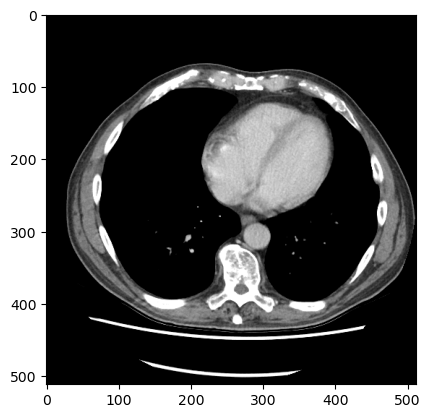

In [327]:
plt.imshow(img_nifiti[:,:,0],cmap='gray')

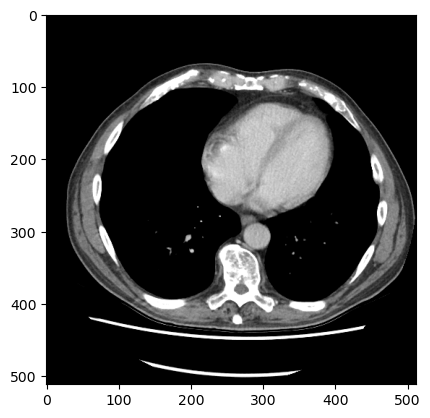

In [296]:
import matplotlib.pyplot as plt

plt.imshow(img_dicom,cmap='gray')

In [368]:
a = img_nifiti[68,211,0] -img_dicom[68,211]

img_nifiti[68,211,0] - img_dicom[68,211]


C:\Users\098986\AppData\Local\Temp\ipykernel_4716\369457355.py:1: RuntimeWarning: overflow encountered in scalar subtract
  a = img_nifiti[68,211,0] -img_dicom[68,211]
C:\Users\098986\AppData\Local\Temp\ipykernel_4716\369457355.py:3: RuntimeWarning: overflow encountered in scalar subtract
  img_nifiti[68,211,0] - img_dicom[68,211]


255

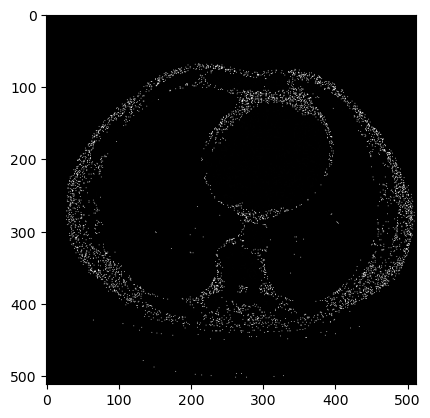

In [337]:
plt.imshow(img_nifiti[:,:,0]-img_dicom,cmap='gray')

In [353]:
a[68,212]

255

In [352]:
a = abs((img_dicom - img_nifiti[:,:,0]))

#the index of the max difference

np.where(a==a.max())

(array([ 68,  68,  68, ..., 502, 502, 502], dtype=int64),
 array([212, 216, 224, ..., 292, 293, 295], dtype=int64))

0

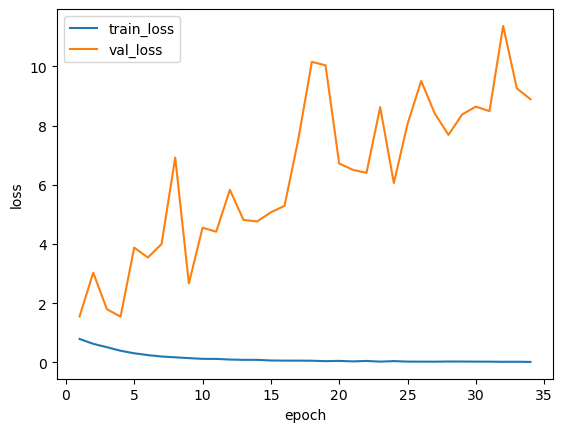

In [113]:
# plot loss
import matplotlib.pyplot as plt
plt.plot(epoch,tr_loss,label='train_loss')
plt.plot(epoch,val_loss,label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Use simple ITK

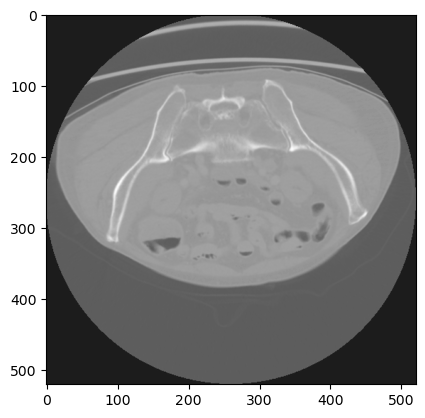

In [167]:
import SimpleITK
import matplotlib.pyplot as plt
#read image
image = SimpleITK.ReadImage('../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_101040_0000.nii.gz')

#get array

image.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
image_array = SimpleITK.GetArrayFromImage(image)
image_array.shape
plt.imshow(image_array[50,:,:],cmap='gray')



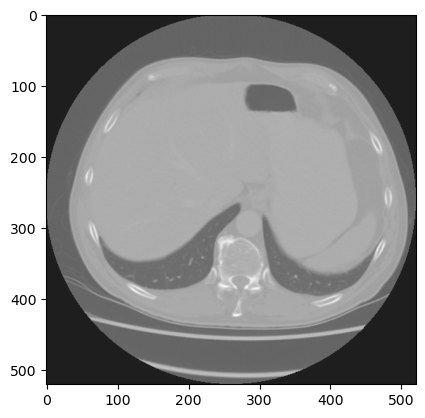

In [212]:
import SimpleITK as sitk

# 读取图像
image = sitk.ReadImage('../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_101040_0000.nii.gz')

# 如果需要沿着x轴翻转图像
flipped_image = sitk.Flip(image, [False, True, False])
flipped_image_array = sitk.GetArrayFromImage(flipped_image)

plt.imshow(flipped_image_array[100,:,:],cmap='gray')

# 保存翻转后的图像
sitk.WriteImage(flipped_image, './Test.nii.gz')


-99

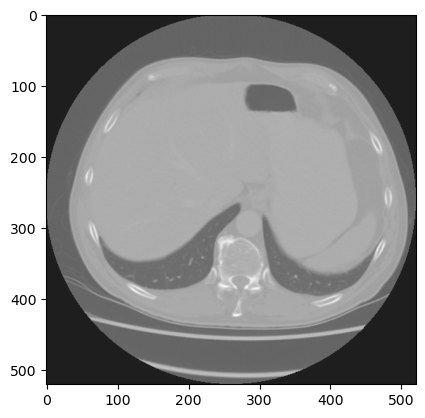

In [219]:
a = SimpleITK.ReadImage('./Test.nii.gz')
a.GetDirection()
plt.imshow(SimpleITK.GetArrayFromImage(a)[100,:,:],cmap='gray')


a_array = SimpleITK.GetArrayFromImage(a)
a_array[97,436,200]

In [222]:
import nibabel as nib
image_nib_array = nib.load('../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_101040_0000.nii.gz').get_fdata()


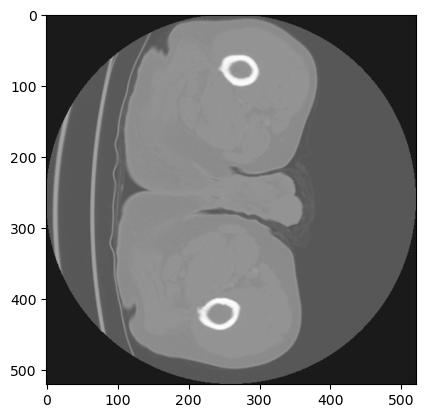

In [229]:
plt.imshow(image_nib_array[:,:,10],cmap='gray')

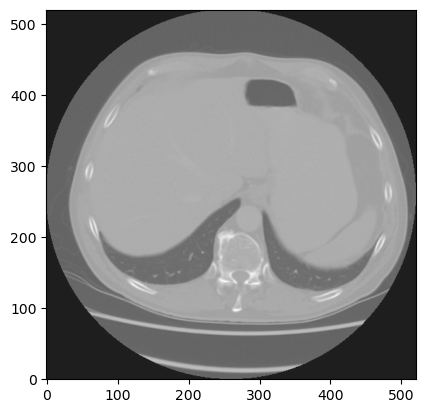

In [231]:
fig, ax = plt.subplots()
ax.imshow(image_array[100,:,:], cmap='gray')
#ax.imshow(image_nib_array[:,:,10], cmap='gray')


# 设置坐标轴的位置，这里'lower'表示将0点设置在左下角
ax.set_ylim(ax.get_ylim()[::-1])
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()

plt.savefig('./test.png',dpi=300)
#plt.show()

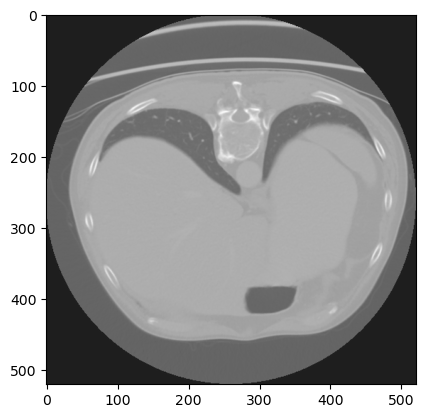

In [199]:
affineTrans =SimpleITK.AffineTransform(3)
affineTrans.SetMatrix([1,0,0,0,1,0,0,0,-1])
affineTrans.SetCenter([1,1,1])


plt.imshow(image_array[100,:,:],cmap='gray')

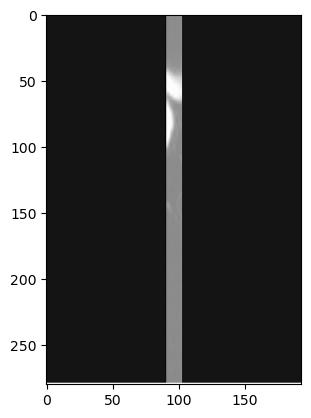

In [150]:
direction = image.GetDirection()
new_direction = (-direction[0], -direction[1], direction[2],
                 -direction[3], -direction[4], direction[5],
                 direction[6], direction[7], direction[8])
image.SetDirection(new_direction)
image_array = SimpleITK.GetArrayFromImage(image)
plt.imshow(image_array[:,:,:],cmap='gray')


In [136]:
direction

(-1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [62]:
train_data.to_csv('../../train_data_4.csv')
vali_data.to_csv('../../vali_data_4.csv')
test_data.to_csv('../../test_data_4.csv')

In [11]:

import monai
import torch

model = monai.networks.nets.resnet10()
model.parameters()

<generator object Module.parameters at 0x00000186E6371F20>

In [33]:
def build_optimizer(parameters,**kwargs):
    print(kwargs)
    return torch.optim.Adam(parameters,**kwargs)


optimizer_param = {"lr":0.001}
optimizer = build_optimizer(model.parameters(),**optimizer_param)

{'lr': 0.001}


In [46]:
from torch.nn import CrossEntropyLoss

class Loss:
    def __init__(self,*args,**kwargs):
        """
        args:
            args only have one loss function
        """
        self.args = args

    def build_loss(self):
        return self.args[0]
    
    def calculate_loss(self,*args):
        pass


CrossEntropyLoss()

In [20]:
from monai.transforms import Compose,EnsureChannelFirst,RandZoom,RandRotate,RandFlip,ToTensor
import inspect
transform_param = {"transform_methods":[
                                EnsureChannelFirst(),
                                # Data augmentation
                                RandZoom(prob = 0.5, min_zoom=1.0, max_zoom=1.2),
                                RandRotate(range_z = 0.35, prob = 0.8),
                                RandFlip(prob = 0.5),
                                # To tensor
                                ToTensor()
                                ]}
transform_param['transform_methods'][1].__dict__


{'_do_transform': True,
 'prob': 0.5,
 '_lazy': False,
 'min_zoom': (1.0,),
 'max_zoom': (1.2,),
 'mode': area,
 'padding_mode': edge,
 'align_corners': None,
 'dtype': torch.float32,
 'keep_size': True,
 'kwargs': {},
 '_zoom': [1.0]}

Test Dataloader


In [8]:
from sklearn.metrics import accuracy_score
import torch
a = torch.tensor([0,1])
b = [0,]
accuracy_score(a,b)

0.5

In [14]:
a = Data_Loader(dataset=dataset,batch_size=1,num_workers=0).build_train_loader()
len(a)

40

# Binary classifaction


In [2]:
import pandas as pd
pvp_label = pd.read_csv('../../Data/CT_Phase/True_Label/Phase_PVP.csv')
#将Phase中的Phase的1和0都换成0,2换成1
pvp_label['Phase'] = pvp_label['Phase'].apply(lambda x: 0 if x == 1 or x==0 else 1)


In [6]:
pvp_label.to_csv('../../Data/CT_Phase/True_Label/Phase_PVP.csv',index=False)




METRICS



In [29]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from monai.metrics import get_confusion_matrix,compute_roc_auc
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
from torch import tensor
from sklearn.metrics import precision_score, recall_score
import torch
import pandas as pd
import numpy as np
class Metrics():
    def __init__(self,num_class=2,y_pred=None,y_true_label=None,targets=None):
        """
        args:
            y_pred: list of predicted tensor
            y_true_label: list of true labels
            targets: dicts of targets and their labels
        """
        self.num_class = num_class
        self.four_rate_dic = {str(i):{'tp':0,'fp':0,'tn':0,'fn':0} for i in range(num_class)}
        self.y_true_label = np.array(y_true_label)
        self.y_pred_label = [torch.argmax(y_pre,dim=1).detach().cpu().numpy().tolist() for y_pre in y_pred]
        self.y_pred_label = [item for sublist in self.y_pred_label for item in sublist]

        self.y_pred_label = np.array(self.y_pred_label)
        self.y_pred_one_hot = torch.nn.functional.one_hot(torch.tensor(self.y_pred_label,dtype=torch.int64),num_classes=self.num_class)
        self.y_true_one_hot = torch.nn.functional.one_hot(torch.tensor(self.y_true_label.tolist(),dtype=torch.int64),num_classes=self.num_class)
    
    def calculate_metrics(self):
        self.metrics = {str(i): {'f1': 0, 'auc': 0, 'accuracy': 0, 'precision': 0, 'recall': 0} for i in range(self.num_class)}

        for i in range(self.num_class):
            true_binary = (self.y_true_label == i).astype(int)
            pred_binary = (self.y_pred_label == i).astype(int)
            print(true_binary,pred_binary,666)
            self.metrics[str(i)]['f1'] = f1_score(true_binary, pred_binary)
            self.metrics[str(i)]['precision'] = precision_score(true_binary, pred_binary)
            self.metrics[str(i)]['recall'] = recall_score(true_binary, pred_binary)

            if len(np.unique(true_binary)) > 1:
                self.metrics[str(i)]['auc'] = roc_auc_score(true_binary, self.y_pred_one_hot[:, i])

            self.metrics[str(i)]['accuracy'] = accuracy_score(true_binary, pred_binary)

        return self.metrics



    def get_roc(self,average='macro'):
        return compute_roc_auc(self.y_pred_one_hot,self.y_true_one_hot,average)
        

    def get_four_rate(self) -> tensor:
        """
        args:
            y_pred: (B,C) one-hot tensor
            y_true: (B,C) one-hot tensor
        """
        confu_matrix = get_confusion_matrix(self.y_pred_one_hot,self.y_true_one_hot)
        #calculate tp,fp,tn,fn
        for i in range(self.num_class):
            self.four_rate_dic[str(i)]['tp'] += confu_matrix[:,i,0].sum()
            self.four_rate_dic[str(i)]['fp'] += confu_matrix[:,i,1].sum() 
            self.four_rate_dic[str(i)]['tn'] += confu_matrix[:,i,2].sum() 
            self.four_rate_dic[str(i)]['fn'] += confu_matrix[:,i,3].sum()
        return self.four_rate_dic
    
    def get_accuracy(self) -> float:
        """
        args:
            y_pred_label: list of predicted labels
            y_true_label: list of true labels
        """
        accuracy = accuracy_score(self.y_pred_label,self.y_true_label)
        return accuracy
    
    def get_f1_score(self,average='macro') -> float:
        return f1_score(self.y_pred_label,self.y_true_label,average=average)
    

    def generate_metrics_df(self,epoch):

        # 将指标数据整理成列表形式
        metrics_data = []
        for class_id, class_metrics in self.metrics.items():
            data_row = {"epoch": epoch}  # 首先添加 epoch
            data_row.update({"class_id": class_id})  # 然后添加 class_id
            data_row.update(class_metrics)  # 最后添加其他指标
            metrics_data.append(data_row)



        # 创建DataFrame
        df = pd.DataFrame(metrics_data)

        return df


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 定义网络结构
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# 参数设置
input_size = 784  # 例如，28x28的图像展平后的大小
hidden_size = 100  # 隐藏层的大小
num_classes = 10   # 类别数，例如MNIST手写数字识别为10

# 创建网络
model = SimpleNet(input_size, hidden_size, num_classes)

# 假设我们有一些随机数据作为输入
batch_size = 2 # 批量大小
x = torch.randn(batch_size, input_size)  # 生成随机数据

# 前向传播
output = model(x)


# 输出结果
print(output.shape)  # 应该是 [batch_size, num_classes]

metrics = Metrics(10,y_pred=[output],y_true_label=[1 for i in range(2)])
metrics.calculate_metrics()

torch.Size([2, 10])
[0 0] [0 0] 666
[1 1] [0 0] 666
[0 0] [0 0] 666
[0 0] [0 0] 666
[0 0] [0 0] 666
[0 0] [0 0] 666
[0 0] [0 0] 666
[0 0] [0 0] 666
[0 0] [1 1] 666
[0 0] [0 0] 666


c:\Users\098986\AppData\Local\anaconda3\envs\CILM\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\098986\AppData\Local\anaconda3\envs\CILM\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\098986\AppData\Local\anaconda3\envs\CILM\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\098986\AppData\Loc

{'0': {'f1': 0.0, 'auc': 0, 'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0},
 '1': {'f1': 0.0, 'auc': 0, 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0},
 '2': {'f1': 0.0, 'auc': 0, 'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0},
 '3': {'f1': 0.0, 'auc': 0, 'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0},
 '4': {'f1': 0.0, 'auc': 0, 'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0},
 '5': {'f1': 0.0, 'auc': 0, 'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0},
 '6': {'f1': 0.0, 'auc': 0, 'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0},
 '7': {'f1': 0.0, 'auc': 0, 'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0},
 '8': {'f1': 0.0, 'auc': 0, 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0},
 '9': {'f1': 0.0, 'auc': 0, 'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0}}

# Timm Resnet18

In [9]:
import torch
import timm
from torch import nn

# 确保你的类别数
num_classes = 10

# 加载预训练的resnet18模型
model = timm.create_model('resnet18', pretrained=True)

# 修改最后的全连接层以适应你的类别数
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 一个简单的前向传递示例
def forward(x):
    return model(x)

# 测试模型
x = torch.randn(1, 3, 100, 100)  # 一个假设的输入张量
output = forward(x)
print(output.shape)  # 应该是 [1, num_classes]


torch.Size([1, 10])


In [13]:
output

tensor([[-0.0618, -0.0941,  0.1946, -0.2964,  0.0383,  0.0465, -0.2030, -0.2793,
          0.1523, -0.2352]], grad_fn=<AddmmBackward0>)

In [2]:
import torch
import sys
import os


c:\Users\098986\AppData\Local\anaconda3\envs\CILM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sys.path.append('../')
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from Core.Utils import  Swin_Transformer_Classification

model = Swin_Transformer_Classification.SwinUNETR(img_size=256,in_channels=1, num_classes=2, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],out_channels=1)

#model_dict = torch.load('../../Output/SwingTransformer/Test_local/fold0/best_metric_1.pth')

#model.load_state_dict(model_dict['model'])




welcome to Utils


In [5]:
model.eval()
with torch.no_grad():

    output = model(torch.randn(1,1,256,256,32))

torch.Size([1, 1, 256, 256, 32]) this is x shape
torch.Size([1, 24, 128, 128, 16]) after embed
torch.Size([1, 24, 128, 128, 16]) this is x0 shape
fucking dhw 133 133 21
torch.Size([1, 48, 64, 64, 8]) this is x1 shape
fucking dhw 70 70 14
torch.Size([1, 96, 32, 32, 4]) this is x2 shape
fucking dhw 35 35 4
fucking dhw 21 21 2
hidden states out torch.Size([1, 384, 8, 8, 1])


In [36]:
output

tensor([[-0.7649, -0.6088]])